In [1]:
!pip install segmentation-models-pytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/home/jupyter/data'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
from pathlib import Path

from tqdm.notebook import tqdm

import sys, os, random, time
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

import rasterio
from rasterio.windows import Window

import albumentations as A
import albumentations as albu

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import segmentation_models_pytorch as smp

In [5]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [6]:
DATA_PATH = Path('/home/jupyter/data/')
assert DATA_PATH.exists()

In [7]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [8]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [9]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels' of function 'rle_numba'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-8-313ecb27751d>", line 2:
@numba.njit()
def rle_numba(pixels):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [10]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [11]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
54f2eec69,124601765 36 124632133 109 124662536 147 12469...
1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [12]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [13]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def read_from_slice(dataset, x1, x2, y1, y2):
    image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
    image = np.moveaxis(image, 0, -1)
    return image

class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, window=256, overlap=32, threshold = 100):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.threshold = overlap, window, transform, threshold
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            assert filepath.exists()
            self.files.append(filepath)
            with rasterio.open(filepath, transform = identity) as dataset:
                dataset_shape = dataset.shape
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
                slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)
                # Only including slices above a specific threshold
                # Note: we are potentially throwing away some data here
                for slc in slices:
                    x1, x2, y1, y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                        self.slices.append([i,x1,x2,y1,y2])
                    else:
                        self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        return image, mask
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename, transform = identity) as dataset:
                image = read_from_slice(dataset, x1, x2, y1, y2)
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped}'

In [14]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256
MINI_SIZE=NEW_SIZE // 2

def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        
        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        )
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [15]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256
MINI_SIZE=NEW_SIZE // 2

def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ColorJitter (brightness=0.07, contrast=0.07,
                       saturation=0.1, hue=0.1, always_apply=False, p=0.3)
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

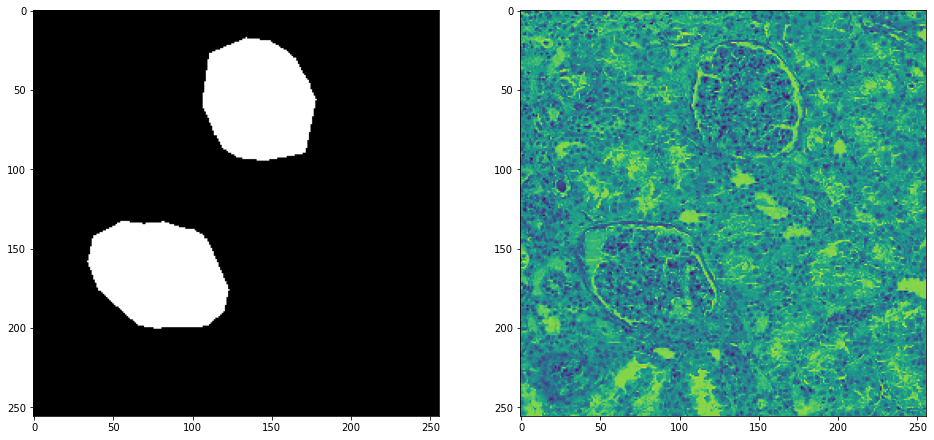

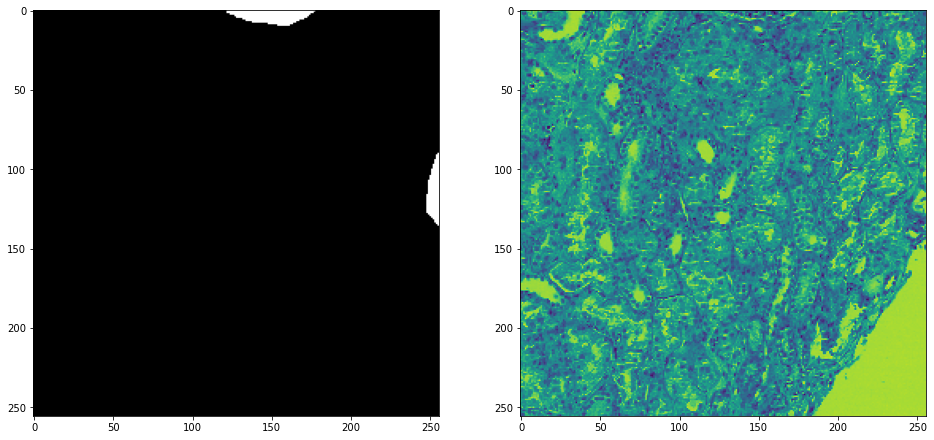

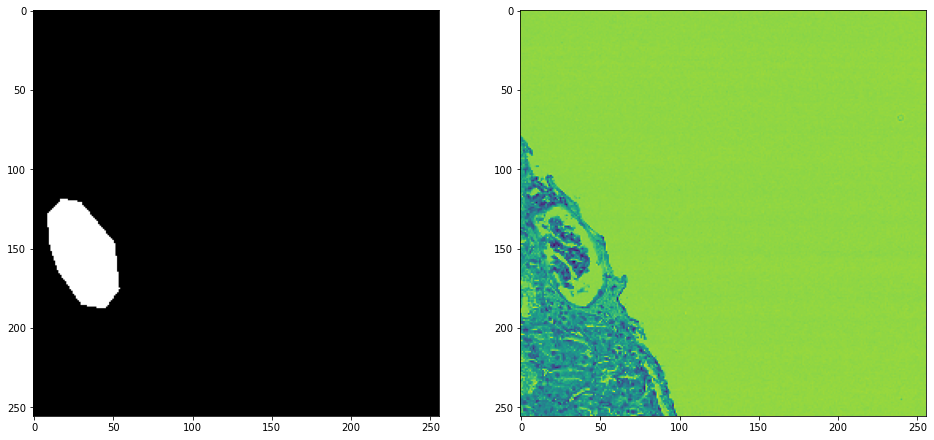

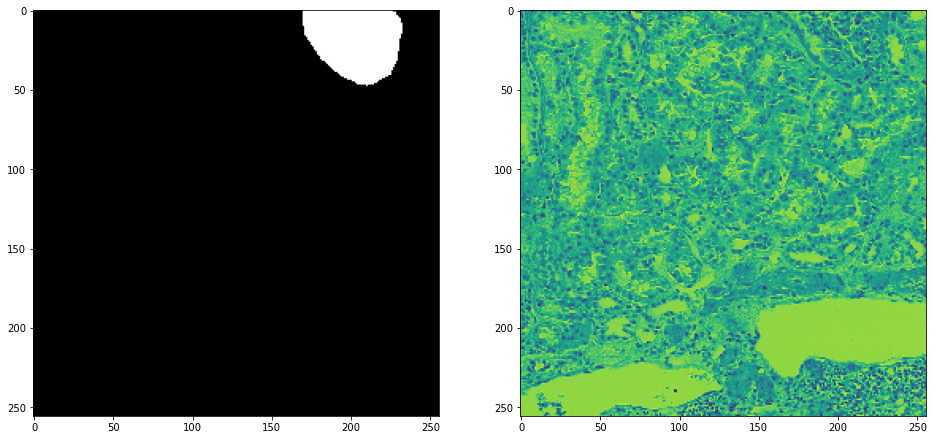

In [16]:
def display_mask_img(idx):
    image, mask = ds[idx]
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(image[0]);

display_mask_img(2)
display_mask_img(1)
display_mask_img(0)
display_mask_img(3)

In [17]:
image, mask = ds[2]

_ = rle_numba_encode(mask[0]) # compile function with numba

#### Split

In [18]:
def create_split_on_index(img_index = 7):
    valid_idx, train_idx = [], []
    for i in range(len(ds)):
        if ds.slices[i][0] == img_index:
            valid_idx.append(i)
        else:
            train_idx.append(i)
    return valid_idx, train_idx

#### Data loaders

In [19]:
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    return train_dl, valid_dl

In [21]:
def get_mean_std(train_dl):
    '''
    Calculate the mean and std
    var = E[x**2] - E[x]**2
    '''
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(train_dl, total=len(train_dl)):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    assert num_batches == len(train_dl)
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

In [22]:
# Checking out the available models in torchvision

for e in dir(torchvision.models.segmentation):
    if(e.find('__') == -1):
        print(e)

DeepLabV3
FCN
_utils
deeplabv3
deeplabv3_resnet101
deeplabv3_resnet50
fcn
fcn_resnet101
fcn_resnet50
segmentation


### Model

In [23]:
def get_model():
    model = torchvision.models.segmentation.deeplabv3_resnet50(True)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

### Training

In [24]:
LR = 1e-3
WD = 1e-1
BEST_MODEL = 'best_model.pth'

In [25]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [26]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8 * bce + 0.2 * dice

In [27]:
def dice_metric(y_pred, y, epsilon = 1.0):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [28]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

In [29]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu"):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        
        optim.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(image)['out']
            loss = criterion(output, target)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optim)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        train_loss.append(loss.item())
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [30]:
def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    dice_metrics = []
    iou_metrics = []

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)['out']
            loss = criterion(output, target)
            dice_metrics.append(dice_metric(output, target))
            iou_metrics.append(iou_metric(output, target))
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metrics = [x.item() for x in dice_metrics]
    iou_metrics = [x.item() for x in iou_metrics]
    dice_metric_mean = np.array(dice_metrics).mean()
    iou_metric_mean = np.array(iou_metrics).mean()
    return dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean

In [31]:
def train(epochs, train_dl, valid_dl, optimizer, scheduler):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []

    for epoch in tqdm(range(epochs)):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(np.array(dice_metrics).mean())
        if best_metric < dice_metric_mean:
            best_metric = dice_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}) iou metric ({iou_metric_mean}).')
        
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [32]:
# reset_mask_path()
# !mkdir {MASK_PATH}

In [33]:
EPOCHS = 20

In [34]:
def train_split(split):
    global model
    model = get_model()
    model.to(DEVICE)
    valid_idx, train_idx = create_split_on_index(split)
    f'Proportions valid / train: {len(valid_idx) / len(train_idx)}'
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(EPOCHS, train_dl, valid_dl, optimizer, scheduler)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [35]:
def train_split_and_move(split):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(split)
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    !mv {BEST_MODEL} {split}_{BEST_MODEL}

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.7304495920737585
Epoch 0 - valid loss: 0.7525114864110947
Saving model
Epoch 0 - val best loss 0.7525114864110947 dice metric (0.19199590012431145) iou metric (0.07894953526556492).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.638005850215753
Epoch 1 - valid loss: 0.7015858292579651
Saving model
Epoch 1 - val best loss 0.7015858292579651 dice metric (0.32330311089754105) iou metric (0.30585528910160065).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.40093934039274853
Epoch 2 - valid loss: 0.40793584287166595
Saving model
Epoch 2 - val best loss 0.40793584287166595 dice metric (0.5718108043074608) iou metric (0.5285598561167717).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.2130984819183747
Epoch 3 - valid loss: 0.19209402799606323
Saving model
Epoch 3 - val best loss 0.19209402799606323 dice metric (0.7058126032352448) iou metric (0.7267436683177948).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.1260447654252251
Epoch 4 - valid loss: 0.13821105286478996
Saving model
Epoch 4 - val best loss 0.13821105286478996 dice metric (0.7195078432559967) iou metric (0.7267433106899261).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.09790100653966267
Epoch 5 - valid loss: 0.13862218521535397
Epoch 5 - val best loss 0.13821105286478996 dice metric (0.6825636178255081) iou metric (0.7159185409545898).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.09007410208384196
Epoch 6 - valid loss: 0.11555035039782524
Saving model
Epoch 6 - val best loss 0.11555035039782524 dice metric (0.7510142624378204) iou metric (0.733806774020195).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.08041217519591252
Epoch 7 - valid loss: 0.1518443189561367
Epoch 7 - val best loss 0.11555035039782524 dice metric (0.68495774269104) iou metric (0.6666187793016434).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.07722464622929692
Epoch 8 - valid loss: 0.12033317983150482
Epoch 8 - val best loss 0.11555035039782524 dice metric (0.7208816558122635) iou metric (0.7441193610429764).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.07206746439139049
Epoch 9 - valid loss: 0.10389094986021519
Saving model
Epoch 9 - val best loss 0.10389094986021519 dice metric (0.7620131224393845) iou metric (0.7729135453701019).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.06913334938387077
Epoch 10 - valid loss: 0.09847590699791908
Saving model
Epoch 10 - val best loss 0.09847590699791908 dice metric (0.7787965685129166) iou metric (0.7806915193796158).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.06462246319279075
Epoch 11 - valid loss: 0.09848210029304028
Saving model
Epoch 11 - val best loss 0.09847590699791908 dice metric (0.780718594789505) iou metric (0.7849729210138321).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.0619876168978711
Epoch 12 - valid loss: 0.09214750677347183
Saving model
Epoch 12 - val best loss 0.09214750677347183 dice metric (0.7833211869001389) iou metric (0.7983299046754837).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.05950429383665323
Epoch 13 - valid loss: 0.09402230009436607
Epoch 13 - val best loss 0.09214750677347183 dice metric (0.7818892002105713) iou metric (0.7906002402305603).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.056235807637373604
Epoch 14 - valid loss: 0.09828026965260506
Epoch 14 - val best loss 0.09214750677347183 dice metric (0.7689894735813141) iou metric (0.7959957867860794).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.054984384371588625
Epoch 15 - valid loss: 0.09125509671866894
Saving model
Epoch 15 - val best loss 0.09125509671866894 dice metric (0.7883699834346771) iou metric (0.7944960743188858).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.05165323056280613
Epoch 16 - valid loss: 0.09365837275981903
Epoch 16 - val best loss 0.09125509671866894 dice metric (0.7791220992803574) iou metric (0.8006841838359833).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.051047833636403084
Epoch 17 - valid loss: 0.09035571850836277
Saving model
Epoch 17 - val best loss 0.09035571850836277 dice metric (0.7905498594045639) iou metric (0.8018260300159454).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.04961093266805013
Epoch 18 - valid loss: 0.09333053417503834
Epoch 18 - val best loss 0.09035571850836277 dice metric (0.7801115214824677) iou metric (0.7942646890878677).


  0%|          | 0/24 [00:00<?, ?it/s]

Train loss: 0.04914403287693858
Epoch 19 - valid loss: 0.09132032282650471
Epoch 19 - val best loss 0.09035571850836277 dice metric (0.7825180143117905) iou metric (0.8023325949907303).


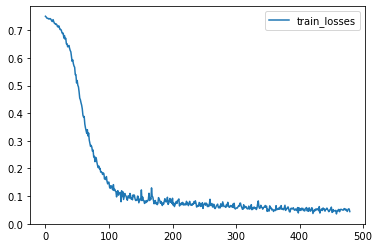

In [36]:
train_split_and_move(7)

In [37]:
# train_split_and_move(0)

In [38]:
# train_split_and_move(1)

In [39]:
# train_split_and_move(2)

In [40]:
# train_split_and_move(3)

In [41]:
# train_split_and_move(4)

In [42]:
!mv *.pth models